# TimePoint - Usage Example
The following tutorial contains the following:
1. Init TimePoint and load pretrained weights
2. Init `SynthAlign` and visualize signals and keypoints
3. Plot TimePoint keypoints and descriptors
4. Choose keypoint according to threshold or choose the top-K according to their probabilites. 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import torch
import numpy as np
import matplotlib.pyplot as plt

from TimePoint.utils.kp_utils import get_topk_in_original_order
from TimePoint.models.timepoint import TimePoint
from TimePoint.data.synthetic_dataset import SynthAlign
from TimePoint.utils.plotting import plot_signal_with_poi, visualize_keypoints





In [2]:
# Jupyter args
# load changes from imports every 2 seconds
%load_ext autoreload
%autoreload 2

# Matplotlib
%matplotlib inline

# Load Pretrained Model

In [3]:
# Pre-trained model paths
# SynthAlign 
synth_path = "../TimePoint/models/pretrained_weights/synth_only.pth"
# SynthAlign + Fine-tune UCR
UCR_path = "../TimePoint/models/pretrained_weights/synth_and_ucr.pth"

model_path = synth_path




In [ ]:
encoder_dims = [128, 128, 256, 256]
encoder_type = "wtconv" # dense, wtconv

# init model and load weights
descriptor_dim = 256
device = "cuda"
timepoint = TimePoint(input_channels=1,
                      encoder_dims=encoder_dims,
                      descriptor_dim=descriptor_dim,
                      encoder_type=encoder_type
                      )

timepoint.load_state_dict(torch.load(model_path))
timepoint = timepoint.to(device)

Total number of trainable parameters: 200329
Encoder parameters: 132224
Detector head parameters: 2313
Descriptor head parameters: 65792


In [5]:
timepoint

TimePoint(
  (encoder): WTConvEncoder1D(
    (layer1): ConvBlock1D(
      (layer): Sequential(
        (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=same)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (layer2): WTConvBlock1D(
      (layer): Sequential(
        (0): WTConv1d(
          (base_conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same, groups=128)
          (base_scale): _ScaleModule()
          (wavelet_convs): ModuleList(
            (0-2): 3 x Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same, groups=256, bias=False)
          )
          (wavelet_scale): ModuleList(
            (0-2): 3 x _ScaleModule()
          )
        )
        (1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
      )
    )
    (layer3): WTConvBlock1D(


# SynthAlign

In [6]:
# sine, block, sawtooth, RBF
probas = [0.6, 0.15, 0.05, 0.2]
data_length = 512
# dataset "size"
N_data = 100
transform = None
# Init
synth_dataset = SynthAlign(
        data_types=[SynthAlign.sine_wave_composition, SynthAlign.block_wave,
                    SynthAlign.sawtooth_wave, SynthAlign.radial_basis_function],
        probs=probas,
        data_length=data_length,
        total_samples=N_data,
        cache_size=0,
        transform=transform
        )

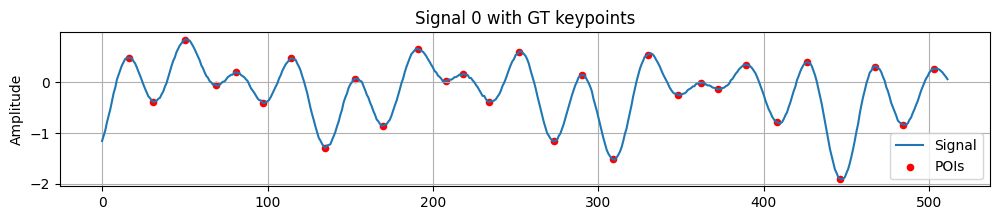

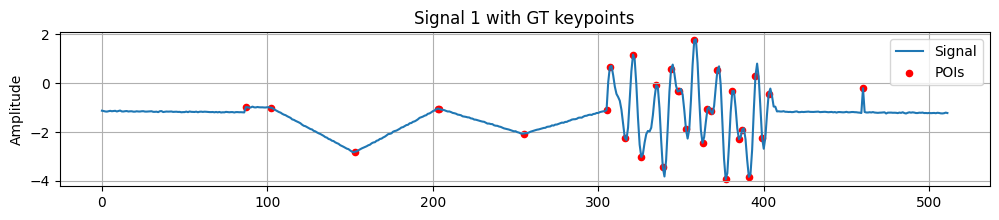

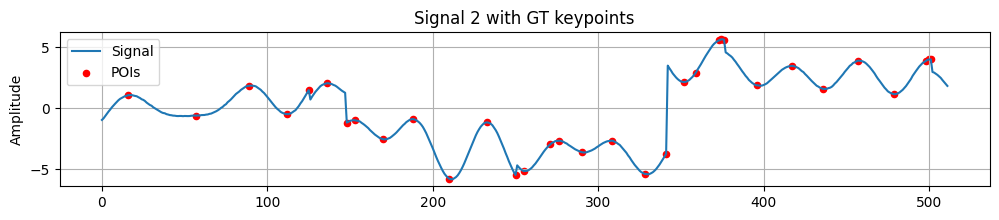

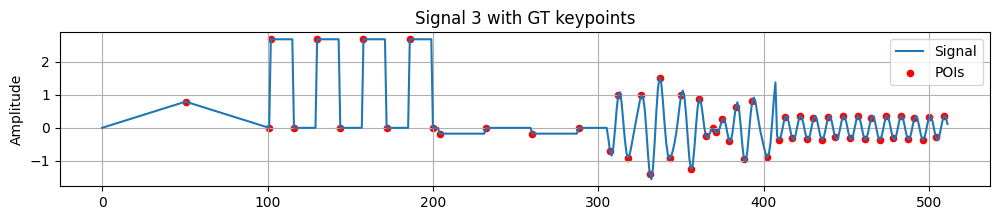

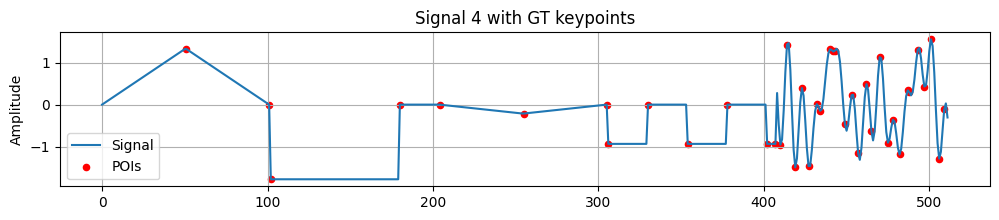

In [7]:
for i in range(5):
    data_dict = synth_dataset[i]
    # (1, L), (L,)
    X_i, keypoints_i = data_dict["signals"], data_dict["keypoints"]
    plot_signal_with_poi(X_i.squeeze(), keypoints_i, title=f"Signal {i} with GT keypoints")

# Plot Predictions

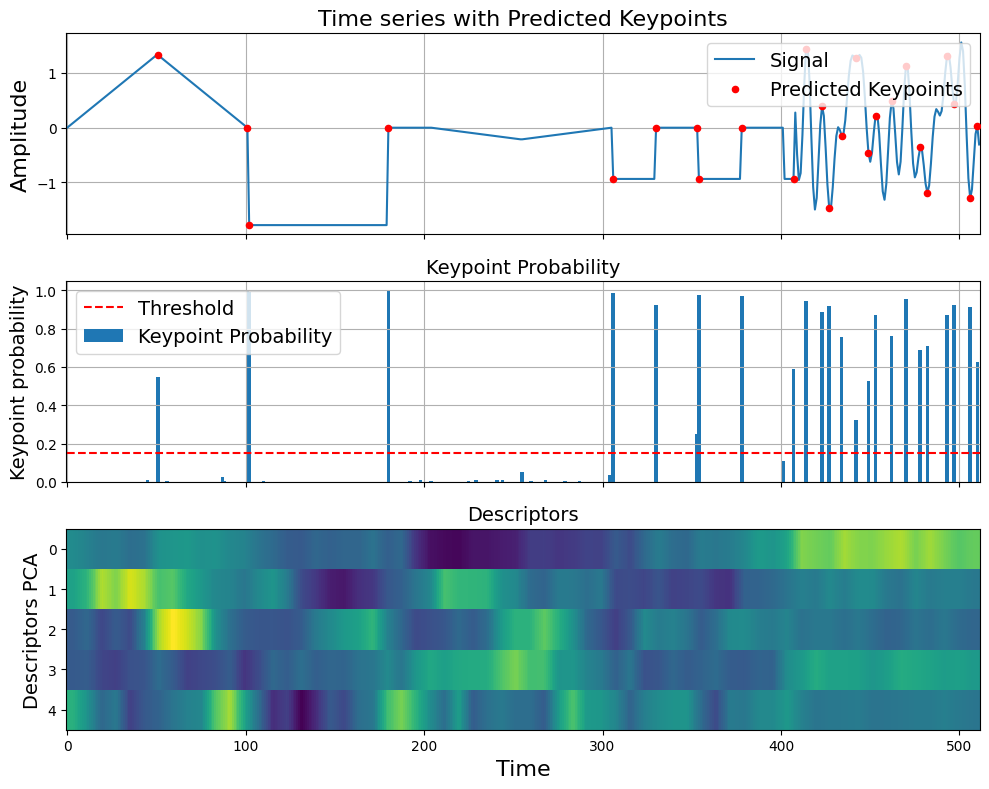

In [8]:
# X (N, C, L), adding batch dim
X_batch = X_i.unsqueeze(0).to(device)
visualize_keypoints(X_batch, timepoint, threshold=0.15, max_plots=5, window_size=7)

# TopK Keypoints

In [9]:
kp_percentage = 0.1
nms_window = 5
# (1, num_kp), (1, 256, num_kp), (1, 256, L)
sorted_topk_indices, detection_proba, descriptors = timepoint.get_topk_points(X_batch, kp_percentage, nms_window)
# Prepare for plotting
sorted_topk_indices = sorted_topk_indices.cpu().squeeze().numpy()
# convert list of indicies of length num_kp to bool array of length L
kp_binary = np.zeros_like(X_i.squeeze())
kp_binary[sorted_topk_indices] = 1

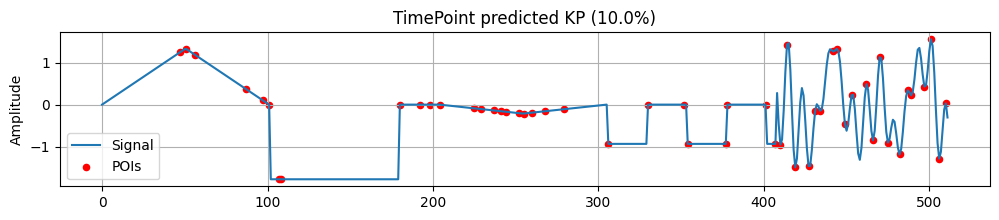

In [10]:
plot_signal_with_poi(X_i.squeeze(), kp_binary, title=f"TimePoint predicted KP ({kp_percentage*100}%)")